In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import os

In [2]:
df = pd.read_csv("transactions_aug_oct_2025_aligned.csv")

In [3]:
df.head()

,ref_id,txn_type,msg_id,mti,blr_category,response_code,payment_channel,cou_mnthly_count,cou_request_ts,cou_id,...,clearing_ts,txn_channel,txn_payment_mode,bou_count_month,cou_count_month,blr_type,asdt,cou_name,bou_name,blr_name
0,S5U7TNUZOTZ5,FETCH,FY3WSU15U4,PAYMENT,Mobile Postpaid,0,Internet,4,2025-08-01 00:00:16.760,CCO7,...,2025-08-01 00:42:15.560,Internet,Wallet,1,3,DTH,01-08-2025,COU_POLAX,BOU_D19JP,BILLER_UEU2T
1,RSO07F5TD89D,FETCH,4EVC3COJB1,PAYMENT,Loan Repayment,0,Mobile,1,2025-08-01 00:03:08.345,WHI4,...,2025-08-01 01:14:21.145,Mobile,UPI,1,2,Landline Postpaid,01-08-2025,COU_SZP8V,BOU_MHNSK,BILLER_Z9CEG
2,SMW3ENTC8F51,FETCH,JCSEPY7XNT,PAYMENT,Landline Postpaid,0,Mobile,3,2025-08-01 00:03:21.459,4JOY,...,2025-08-01 01:23:49.259,Mobile,UPI,1,1,Loan Repayment,01-08-2025,COU_I62PO,BOU_VM66A,BILLER_ZZ8XK
3,CT69PCCHPIXE,PAYMENT,83RFP3093D,FETCH,DTH,0,Mobile,5,2025-08-01 00:03:37.276,ZNJQ,...,2025-08-01 00:27:20.076,Mobile,UPI,5,4,Electricity,02-08-2025,COU_EAY3U,BOU_GODS8,BILLER_VY61W
4,GOYNUFM6KX2M,FETCH,ALBYW2ERBR,PAYMENT,LPG Gas,0,Mobile,2,2025-08-01 00:06:10.541,HO88,...,2025-08-01 00:26:32.341,Mobile,UPI,2,4,Mobile Postpaid,01-08-2025,COU_WVVYM,BOU_ERH4U,BILLER_I9MUP


In [4]:
 
biller_df = (
    df.groupby('blr_name')
      .agg(
          total_txns=('ref_id', 'count'),
          total_amount=('txn_amount', 'sum'),
          avg_amount=('txn_amount', 'mean'),
          total_fee=('blr_fee', 'sum'),
          avg_fee=('blr_fee', 'mean')
      )
      .reset_index()
)

In [5]:
biller_df.head()

,blr_name,total_txns,total_amount,avg_amount,total_fee,avg_fee
0,BILLER_000B9,1,315,315.0,1.26,1.26
1,BILLER_000ZH,1,116,116.0,0.54,0.54
2,BILLER_001L3,1,27,27.0,0.12,0.12
3,BILLER_0036B,1,135,135.0,0.62,0.62
4,BILLER_003G7,1,76,76.0,0.30,0.30


In [6]:
biller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99917 entries, 0 to 99916
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   blr_name      99917 non-null  object 
 1   total_txns    99917 non-null  int64  
 2   total_amount  99917 non-null  int64  
 3   avg_amount    99917 non-null  float64
 4   total_fee     99917 non-null  float64
 5   avg_fee       99917 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.6+ MB


In [7]:
biller_df['blr_name'].unique

<bound method Series.unique of 0        BILLER_000B9
1        BILLER_000ZH
2        BILLER_001L3
3        BILLER_0036B
4        BILLER_003G7
             ...     
99912    BILLER_ZZXF2
99913    BILLER_ZZXH1
99914    BILLER_ZZXMH
99915    BILLER_ZZYN8
99916    BILLER_ZZZ7K
Name: blr_name, Length: 99917, dtype: object>

In [8]:
df1 = pd.read_csv("transactions_1lakh_10_billers_randomized.csv")
df1.head()

,ref_id,txn_type,msg_id,mti,blr_category,response_code,payment_channel,cou_mnthly_count,cou_request_ts,cou_id,...,clearing_ts,txn_channel,txn_payment_mode,bou_count_month,cou_count_month,blr_type,asdt,cou_name,bou_name,blr_name
0,REF_000000,FETCH,FY3WSU15U4,PAYMENT,Mobile Postpaid,0,Internet,4,2025-08-01 00:00:16.760,COUID_07,...,2025-08-01 00:42:15.560,Internet,Wallet,1,3,DTH,01-08-2025,COU_07,BOU_08,BILLER_07
1,REF_000001,FETCH,4EVC3COJB1,PAYMENT,Loan Repayment,0,Mobile,1,2025-08-01 00:03:08.345,COUID_01,...,2025-08-01 01:14:21.145,Mobile,UPI,1,2,Landline Postpaid,01-08-2025,COU_01,BOU_03,BILLER_04
2,REF_000002,FETCH,JCSEPY7XNT,PAYMENT,Landline Postpaid,0,Mobile,3,2025-08-01 00:03:21.459,COUID_04,...,2025-08-01 01:23:49.259,Mobile,UPI,1,1,Loan Repayment,01-08-2025,COU_04,BOU_10,BILLER_08
3,REF_000003,PAYMENT,83RFP3093D,FETCH,DTH,0,Mobile,5,2025-08-01 00:03:37.276,COUID_07,...,2025-08-01 00:27:20.076,Mobile,UPI,5,4,Electricity,02-08-2025,COU_07,BOU_10,BILLER_05
4,REF_000004,FETCH,ALBYW2ERBR,PAYMENT,LPG Gas,0,Mobile,2,2025-08-01 00:06:10.541,COUID_05,...,2025-08-01 00:26:32.341,Mobile,UPI,2,4,Mobile Postpaid,01-08-2025,COU_05,BOU_01,BILLER_07


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ref_id              100000 non-null  object 
 1   txn_type            100000 non-null  object 
 2   msg_id              100000 non-null  object 
 3   mti                 100000 non-null  object 
 4   blr_category        100000 non-null  object 
 5   response_code       100000 non-null  int64  
 6   payment_channel     100000 non-null  object 
 7   cou_mnthly_count    100000 non-null  int64  
 8   cou_request_ts      100000 non-null  object 
 9   cou_id              100000 non-null  object 
 10  bou_request_ts      100000 non-null  object 
 11  bou_id              100000 non-null  object 
 12  bou_repsonse_ts     100000 non-null  object 
 13  bou_status          100000 non-null  object 
 14  cou_response_ts     100000 non-null  object 
 15  cou_status          100000 non-null

In [10]:
biller_df1 = (
    df1.groupby('blr_name')
      .agg(
          total_txns=('ref_id', 'count'),
          total_amount=('txn_amount', 'sum'),
          avg_amount=('txn_amount', 'mean'),
          total_fee=('blr_fee', 'sum'),
          avg_fee=('blr_fee', 'mean')
      )
      .reset_index()
)

In [11]:
biller_df1

,blr_name,total_txns,total_amount,avg_amount,total_fee,avg_fee
0,BILLER_01,9974,2946754,295.443553,11789.97,1.182070
1,BILLER_02,9911,2981941,300.871860,11954.86,1.206221
2,BILLER_03,9886,2948179,298.217580,11811.51,1.194771
3,BILLER_04,9984,2974517,297.928385,11877.09,1.189612
4,BILLER_05,9975,3085481,309.321404,12370.56,1.240156
5,BILLER_06,10054,3023301,300.706286,12109.36,1.204432
6,BILLER_07,10104,3043950,301.261876,12165.23,1.204001
7,BILLER_08,9925,2951835,297.414106,11815.22,1.190450
8,BILLER_09,10031,2995548,298.629050,11976.53,1.193952
9,BILLER_10,10156,3018985,297.261225,12089.55,1.190385


In [12]:
#converting txn_date to actual date format
df1['txn_date']=pd.to_datetime(df1['txn_date'], format='%Y%m%d')

In [13]:
#Daily aggregation - all billers combined

daily_all_billers = (df1.groupby('txn_date').agg(
    total_transactions=('ref_id', 'count'),
    total_amount = ('txn_amount','sum'),
    total_biller_fee = ('blr_fee', 'sum')
)
                     .reset_index())

In [14]:
daily_all_billers.head()

,txn_date,total_transactions,total_amount,total_biller_fee
0,2025-08-01,942,282519,1129.24
1,2025-08-02,892,260607,1039.69
2,2025-08-03,901,269715,1071.34
3,2025-08-04,823,244733,979.43
4,2025-08-05,884,260503,1036.13


In [15]:
#daily aggregation - per biller
daily_per_biller = (
    df1.groupby(['txn_date', 'blr_name'])
      .agg(
          total_transactions=('ref_id', 'count'),
          total_amount=('txn_amount', 'sum'),
          total_biller_fee=('blr_fee', 'sum')
      )
      .reset_index()
)

In [16]:
daily_per_biller.head()

,txn_date,blr_name,total_transactions,total_amount,total_biller_fee
0,2025-08-01,BILLER_01,114,32049,128.01
1,2025-08-01,BILLER_02,80,29854,118.65
2,2025-08-01,BILLER_03,104,31550,126.33
3,2025-08-01,BILLER_04,84,24632,96.45
4,2025-08-01,BILLER_05,103,32875,132.13


In [17]:
# Create a 'week_start' column for grouping by week
df1['week_start'] = df1['txn_date'] - pd.to_timedelta(df1['txn_date'].dt.weekday, unit='d')

# 5a. Weekly all billers combined
weekly_all_billers = (
    df1.groupby('week_start')
      .agg(
          total_transactions=('ref_id', 'count'),
          total_amount=('txn_amount', 'sum'),
          total_biller_fee=('blr_fee', 'sum')
      )
      .reset_index()
)

In [18]:
weekly_all_billers.head()

,week_start,total_transactions,total_amount,total_biller_fee
0,2025-07-28,2735,812841,3240.27
1,2025-08-04,6103,1819584,7289.30
2,2025-08-11,6315,1917750,7655.83
3,2025-08-18,7967,2398402,9587.55
4,2025-08-25,6297,1871579,7481.49


In [19]:
#Weekly per biller
weekly_per_biller = (
    df1.groupby(['week_start', 'blr_name'])
      .agg(
          total_transactions=('ref_id', 'count'),
          total_amount=('txn_amount', 'sum'),
          total_biller_fee=('blr_fee', 'sum')
      )
      .reset_index()
)

In [20]:
weekly_per_biller.head()

,week_start,blr_name,total_transactions,total_amount,total_biller_fee
0,2025-07-28,BILLER_01,287,89345,352.40
1,2025-07-28,BILLER_02,270,84347,332.33
2,2025-07-28,BILLER_03,276,87726,352.74
3,2025-07-28,BILLER_04,265,72150,283.82
4,2025-07-28,BILLER_05,292,87818,355.76


In [21]:
#save to CSV files
daily_all_billers.to_csv("daily_all_billers.csv", index=False)
daily_per_biller.to_csv("daily_per_biller.csv", index=False)
weekly_all_billers.to_csv("weekly_all_billers.csv", index=False)
weekly_per_biller.to_csv("weekly_per_biller.csv", index=False)

In [22]:
FILE_PATH = "transactions_1lakh_10_billers_randomized.csv"  # change if needed
OUTPUT_DIR = "biller_segmentation_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
SUCCESS_CODES = {"000", "200"}   # consider these as successful transactions

In [23]:
# AGGREGATE PER BILLER (FEATURE ENGINEERING)
# ---------------------------
# We compute volume, value, averages and fee metrics per biller
agg = (
    df1.groupby('blr_name')
    .agg(
        total_txn_count=('ref_id', 'count'),
        unique_customers=('cust_mobile_num', 'nunique'),   # optional helpful metric
        total_txn_amount=('txn_amount', 'sum'),
        avg_txn_value=('txn_amount', 'mean'),
        total_fee=('blr_fee', 'sum'),
        avg_fee=('blr_fee', 'mean'),
        success_rate=('response_code', lambda s: (s.isin(SUCCESS_CODES)).mean())
    )
    .reset_index()
)

# Derive additional useful features
agg['fee_percent'] = np.where(agg['total_txn_amount'] > 0,
                              (agg['total_fee'] / agg['total_txn_amount']) * 100,
                              0)

# Replace infs / NaNs if any
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

# Save intermediate aggregation
agg.to_csv(os.path.join(OUTPUT_DIR, "biller_aggregation_raw.csv"), index=False)

In [24]:
agg

,blr_name,total_txn_count,unique_customers,total_txn_amount,avg_txn_value,total_fee,avg_fee,success_rate,fee_percent
0,BILLER_01,9974,9974,2946754,295.443553,11789.97,1.182070,0.0,0.400100
1,BILLER_02,9911,9911,2981941,300.871860,11954.86,1.206221,0.0,0.400909
2,BILLER_03,9886,9886,2948179,298.217580,11811.51,1.194771,0.0,0.400637
3,BILLER_04,9984,9984,2974517,297.928385,11877.09,1.189612,0.0,0.399295
4,BILLER_05,9975,9975,3085481,309.321404,12370.56,1.240156,0.0,0.400928
5,BILLER_06,10054,10054,3023301,300.706286,12109.36,1.204432,0.0,0.400534
6,BILLER_07,10104,10104,3043950,301.261876,12165.23,1.204001,0.0,0.399653
7,BILLER_08,9925,9925,2951835,297.414106,11815.22,1.190450,0.0,0.400267
8,BILLER_09,10031,10031,2995548,298.629050,11976.53,1.193952,0.0,0.399811
9,BILLER_10,10156,10156,3018985,297.261225,12089.55,1.190385,0.0,0.400451


In [25]:
# ---------------------------
# 3) SELECT FEATURES FOR CLUSTERING
# ---------------------------
# Choose the numeric characteristics that capture behavior.
# You can add or remove features based on business needs.
feature_cols = [
    'total_txn_count',   # volume
    'total_txn_amount',  # total value
    'avg_txn_value',     # per-transaction value
    'fee_percent',       # revenue characteristic
    # 'unique_customers'  # optional if relevant
]
X = agg[feature_cols].copy()


In [26]:
# ---------------------------
# 4) SCALE FEATURES
# ---------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [27]:
# ---------------------------
# 5) FIND A REASONABLE K (ELBOW + SILHOUETTE)
# ---------------------------
n_billers = X.shape[0]
if n_billers < 2:
    raise ValueError("Not enough billers to cluster. Need at least 2 distinct billers.")

# Try up to min(10, n_billers-1) clusters
max_k = min(10, max(2, n_billers - 1))
inertia_list = []
silhouette_list = []
k_values = list(range(2, max_k + 1))


In [28]:
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia_list.append(km.inertia_)
    # silhouette only defined for k >= 2 and less than n_samples
    try:
        silhouette_list.append(silhouette_score(X_scaled, labels))
    except Exception:
        silhouette_list.append(np.nan)


In [29]:
# Save elbow + silhouette
elbow_df = pd.DataFrame({
    'k': k_values,
    'inertia': inertia_list,
    'silhouette': silhouette_list
})
elbow_df.to_csv(os.path.join(OUTPUT_DIR, "elbow_silhouette.csv"), index=False)


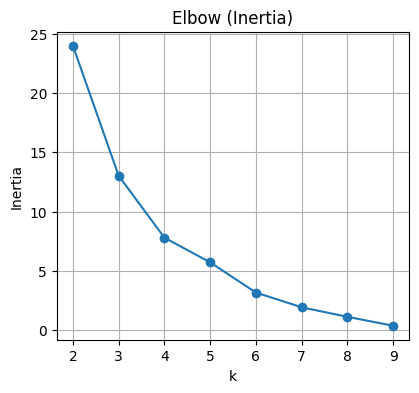

In [30]:
# Plot elbow and silhouette
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(k_values, inertia_list, marker='o')
plt.title('Elbow (Inertia)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)

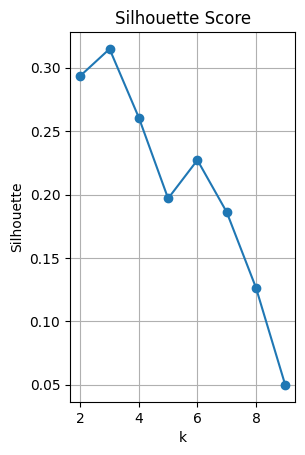

In [31]:
plt.subplot(1,2,2)
plt.plot(k_values, silhouette_list, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)

In [32]:
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "elbow_silhouette.png"))
plt.close()

In [33]:
# Choose optimal k automatically: prefer highest silhouette, fallback to elbow heuristic
#  - pick k with max silhouette (ignoring NaNs). If multiple, pick smallest k among them.
valid_silhouette = elbow_df.dropna(subset=['silhouette'])
if not valid_silhouette.empty:
    best_k = int(valid_silhouette.loc[valid_silhouette['silhouette'].idxmax(), 'k'])
else:
    # fallback: elbow heuristic - pick k where percentage drop in inertia slows
    # simple heuristic: choose k at which inertia relative drop is less than threshold
    rel_drops = np.diff(inertia_list) / inertia_list[:-1]
    candidate = np.argwhere(rel_drops > -0.5)  # keep as fallback
    best_k = k_values[0] if len(candidate)==0 else k_values[min(len(rel_drops)-1, int(candidate[0]))]
best_k = max(2, min(best_k, max_k))


In [34]:
# ---------------------------
# 6) FIT FINAL KMEANS
# ---------------------------
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=50)
agg['cluster'] = kmeans_final.fit_predict(X_scaled)

# Save cluster centers (inverse transform to original scale for interpretability)
centers_scaled = kmeans_final.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=feature_cols)
centers_df['cluster'] = range(best_k)
centers_df.to_csv(os.path.join(OUTPUT_DIR, "cluster_centers.csv"), index=False)

In [35]:
# ---------------------------
# 7) PROFILE CLUSTERS (DESCRIPTIVE)
# ---------------------------
profile = (
    agg.groupby('cluster')
    .agg(
        biller_count=('blr_name', 'count'),
        total_txn_count=('total_txn_count', 'sum'),
        total_txn_amount=('total_txn_amount', 'sum'),
        avg_txn_value=('avg_txn_value', 'mean'),
        avg_fee_percent=('fee_percent', 'mean'),
        unique_customers=('unique_customers', 'sum'),
    )
    .reset_index()
)
profile['txn_count_pct'] = profile['total_txn_count'] / profile['total_txn_count'].sum() * 100
profile['txn_amount_pct'] = profile['total_txn_amount'] / profile['total_txn_amount'].sum() * 100
profile.to_csv(os.path.join(OUTPUT_DIR, "cluster_profile.csv"), index=False)
agg.to_csv(os.path.join(OUTPUT_DIR, "biller_segmentation_clusters.csv"), index=False)

In [ ]:
# ---------------------------
# 8) AUTO-LABEL CLUSTERS (HIGH-LEVEL NAMES)
# ---------------------------
# Use centers to decide labels like "High-Volume-Low-Value" etc.
def name_cluster(center_row):
    vol = center_row['total_txn_count_center']
    val = center_row['total_txn_amount_center']
    avg = center_row['avg_txn_value']
    vol_median = centers_df_for_naming['total_txn_count_center'].median()
    avg_median = centers_df_for_naming['avg_txn_value'].median()

    if avg > avg_median and vol < vol_median:
        return "Low-Volume - High-Value"
    if vol > vol_median and avg < avg_median:
        return "High-Volume - Low-Value"
    if vol > vol_median and avg > avg_median:
        return "High-Volume - High-Value"
    return "Moderate-Volume-Value"


centers_df_for_naming = centers_df.merge(
    profile[['cluster', 'total_txn_count', 'total_txn_amount']],
    on='cluster',
    how='left',
    suffixes=('_center', '_profile')
)
print("columns after merge:\n",centers_df_for_naming.columns )


NameError: name 'centers_df_for_naming' is not defined

In [ ]:
centers_df_for_naming['label'] = centers_df_for_naming.apply(name_cluster, axis=1)
label_map = dict(zip(centers_df_for_naming['cluster'], centers_df_for_naming['label']))
agg['cluster_label'] = agg['cluster'].map(label_map)

# Save final results and label mapping
agg.to_csv(os.path.join(OUTPUT_DIR, "biller_segmentation_with_labels.csv"), index=False)
pd.DataFrame.from_dict(label_map, orient='index', columns=['label']).to_csv(
    os.path.join(OUTPUT_DIR, "cluster_label_map.csv")
)


In [ ]:
print(profile.columns)

In [ ]:
print(centers_df_for_naming.head())

In [ ]:
print(centers_df.columns)